# Импорты

In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
! pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import ConfusionMatrixDisplay 
import pickle
from pickle import load
import joblib
! pip install scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split 
! pip install optuna
import optuna

# Проект по определению упаковочного материала для доставки заказа.

**Общее описание задачи:**

Для того, чтобы пользователь получил
заказ, необходимо упаковать заказанные товары в посылки конечному клиенту.
Компания заметила, что сотрудник тратит большое количество времени для
выбора упаковочного материала в который необходимо упаковать товары.
Существует большое количество упаковочного материала (коробочки,
пакетики). Необходимо придумать способ подсказывать пользователю
информацию о выборе упаковочного материала

**Цель машинного обучения:**

– С высокой точностью рекомендовать правильную упаковку для заказа,
которая позволит доставить товары без порчи клиенту и минимизирует затраты
на упаковочный материал.

# План работы над проектом:

- загрузить данные, представленные заказчиком и изучить их
- выявить закономерности, влияющие на выбор упаковки
- изучить данные об упаковках
- сгенирировать целевой признак на основе имеющейся информации
- разделить выборки на тестовую и обучающую
- обучить модель
- исследовать мерики качества 

In [103]:
# Установка опции для отображения всех столбцов
pd.set_option('display.max_columns', None)

# Загрузка

## Датасет заказы

In [104]:
data = pd.read_csv('data.csv')

Посмртрим на данные:

In [105]:
data.head()

,Unnamed: 0,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


In [106]:
data.describe()

,Unnamed: 0,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.00000,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,162811.00000,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,93999.40769,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.00000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,81405.50000,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,162811.00000,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,244216.50000,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,325622.00000,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


В таблице есть товары с весом, равным нулю. Это явная аномалия, удалим их:

In [107]:
data = data[data['goods_wght'] != 0]

Далее удалим все столбцы, которые в обучении модели участвовать не будут:

In [108]:
data = data.drop(['Unnamed: 0', 'whs', 'selected_cartontype', 'box_num', 'recommended_cartontype', 'sel_calc_cube', 'rec_calc_cube', 
                  'who', 'trackingid', 'pack_volume'], axis=1)

In [109]:
data.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd


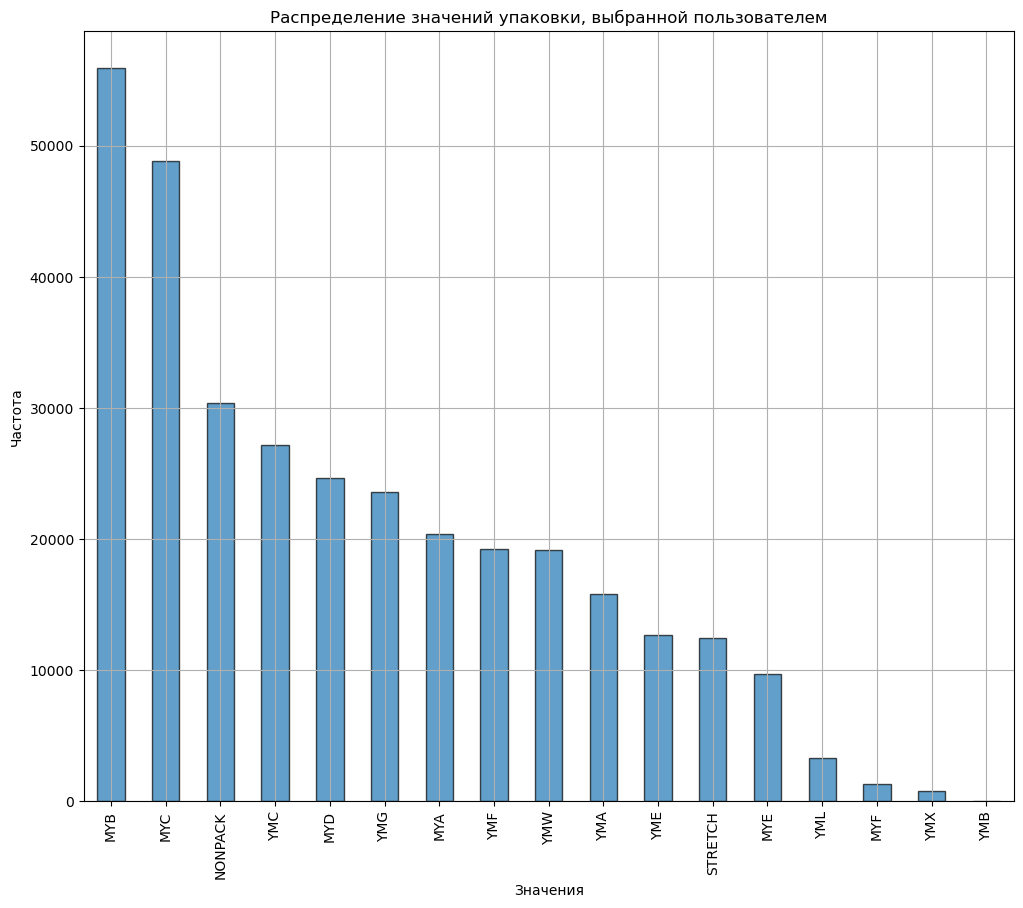

In [110]:
data['selected_carton'].value_counts().plot(kind='bar', alpha=0.7, edgecolor='black', grid=True)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений упаковки, выбранной пользователем')
plt.xticks(rotation=90)  
plt.show()

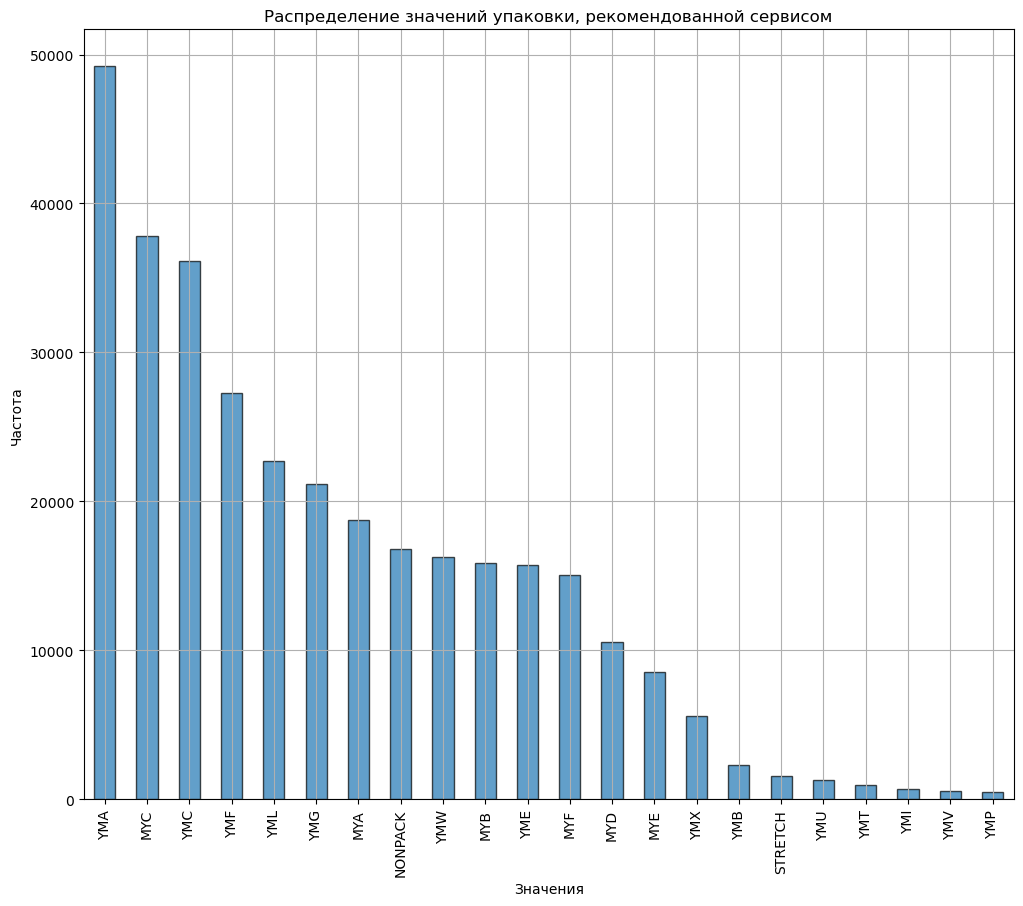

In [111]:
data['recommended_carton'].value_counts().plot(kind='bar', alpha=0.7, edgecolor='black', grid=True)
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.title('Распределение значений упаковки, рекомендованной сервисом')
plt.xticks(rotation=90)  
plt.show()

Сервис предлогает более разнообразный выбор упаковок. Самая популярная упаковка, рекомендованная сервисом - YMA, MYC, YMC. Пользователь чаще всего выбирает MYB, на втором месте также MYC, также пользователь предпочитает не упаковывать товары (NONPACK).

## Датасет Товары

In [112]:
sku = pd.read_csv('sku.csv')

In [113]:
sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


In [114]:
sku = sku.drop('Unnamed: 0', axis=1)

In [115]:
sku.describe()

,a,b,c
count,6.385961e+06,6.385961e+06,6.385961e+06
mean,2.108468e+01,1.203353e+01,1.782524e+01
std,1.890676e+01,1.487745e+01,1.508838e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,3.000000e+00,8.000000e+00
50%,1.800000e+01,8.000000e+00,1.500000e+01
75%,2.800000e+01,1.600000e+01,2.400000e+01
max,6.554000e+03,2.050000e+03,5.930000e+02


Максимальные габариты товара в заказе 6554, 2050, 593 - крупногабаритный груз, скорей всего это единичный случай, далее посмотрим, встречаются ли такие крупногабаритные товары в таблице заказы. Скорей всего их лучше удалить.

## Датасет Категории товаров

In [116]:
sku_cargotypes = pd.read_csv('sku_cargotypes.csv')

In [117]:
sku_cargotypes.head()

,Unnamed: 0,sku,cargotype
0,0,4862bf0e760a593b13f3f2fcf822e533,290
1,1,4862bf0e760a593b13f3f2fcf822e533,901
2,2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,4,24ce9dba9f301ada55f60e25ee1498d2,290


## Датасет Категории

In [118]:
cargotype_info = pd.read_csv('cargotype_info.csv')

In [119]:
cargotype_info = cargotype_info.drop(cargotype_info.columns[0], axis=1)

In [120]:
cargotype_info.head()

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...


## Датасет Характеристика упаковки

In [121]:
carton = pd.read_csv('carton.csv')

In [122]:
carton.drop(['DISPLAYRFPACK'], axis = 1, inplace=True)

In [123]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT
0,YMA,24.7,15.0,10.00
1,YMC,30.0,20.0,15.00
2,YME,30.0,30.0,44.50
3,YMF,35.0,25.0,15.00
4,YMG,44.7,30.0,20.00
5,YMH,42.0,20.0,86.00
6,YMJ,50.0,29.0,48.00
7,KSD,0.0,0.0,0.00
8,YML,60.0,40.0,45.00
9,YMN,60.0,60.0,40.00


## Датасет Цена упаковки

In [124]:
carton_price = pd.read_excel('carton_price.xlsx')

In [125]:
carton_price

,Unnamed: 0,01.03.2023
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722
5,MYF,4.083130
6,YMA,4.392937
7,YMC,7.777487
8,YME,23.670260
9,YMF,10.661487


# Итоговый датасет для обучения

К датасету с заказами прибавим размеры товара из таблицы c уникальными id sku:

In [126]:
df = data.merge(sku, how='inner', on ='sku')

Посмотрим, какой в итоге получили датасет:

In [127]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
1,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
2,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
3,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0
4,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.1,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0


Посчитаем количество уникальных товаров в заказе:

In [128]:
df['count'] = df.groupby(['orderkey', 'sku'])['sku'].transform('count')

In [129]:
df.describe()

,goods_wght,a,b,c,count
count,314755.000000,314755.000000,314755.000000,314755.000000,314755.000000
mean,0.880237,17.954136,11.422808,14.503091,5.296205
std,2.320277,16.553648,9.863107,10.715367,21.309439
min,0.001000,0.000000,0.000000,0.000000,1.000000
25%,0.110000,8.800000,4.700000,7.100000,1.000000
50%,0.300000,14.000000,8.600000,11.000000,1.000000
75%,0.750000,21.500000,16.000000,19.000000,3.000000
max,88.000000,257.000000,240.000000,200.000000,257.000000


Товары с аномальными габаритами не вошли в итоговый датасет. Критичных выбросов нет. 


Посмотрим, сколько коробок у нас обычно в заказе:

In [130]:
grouped = df.groupby('orderkey').agg({'selected_carton': 'nunique', 'recommended_carton': 'nunique', 'sku': 'nunique'})

In [131]:
grouped 

,selected_carton,recommended_carton,sku
orderkey,,,
00004fc4755eeb7e851e52ec91130fe4,1,1,1
00008e765c2d85abfa9c97563afd98ef,1,1,1
0000c268eb1be1dd5b8c1a032f7318fc,1,1,1
0000fc4c7acac6e89f82392b90e47a27,1,1,2
0001963724fa4cc12d4f025056085633,1,1,2
...,...,...,...
fffe13683b35336a4c1bb061f479f05b,1,1,1
ffff1e5d7f5b52f28d733ba01a4589b9,1,1,1
ffff1f0a51126b373f36d7733a5ddb0f,1,1,1


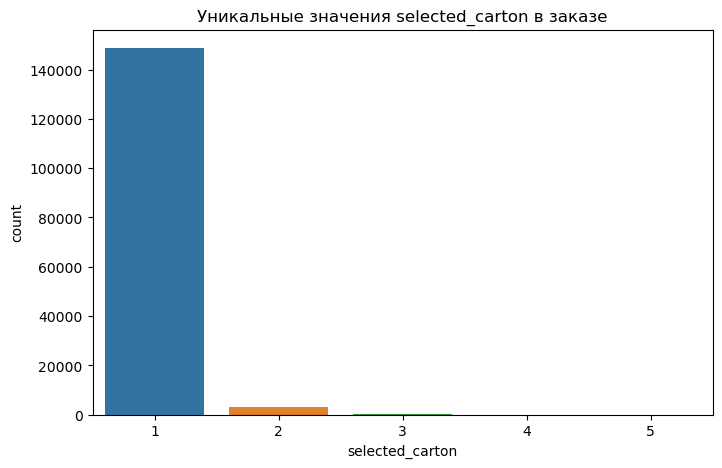

In [132]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df.groupby('orderkey')['selected_carton'].nunique().reset_index(), x='selected_carton')
plt.title('Уникальные значения selected_carton в заказе')
plt.show()


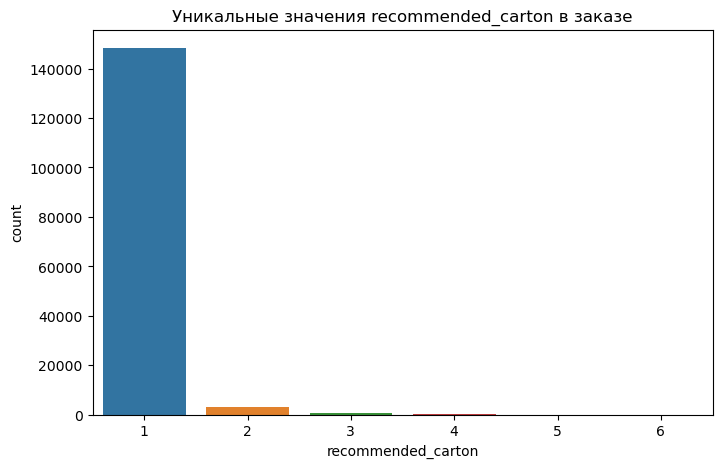

In [133]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df.groupby('orderkey')['recommended_carton'].nunique().reset_index(), x='recommended_carton')
plt.title('Уникальные значения recommended_carton в заказе')
plt.show()

Из графиков видно, что для всего заказа чаще используется только одна коробка. Очень редко 2 и 3, больше трех наименований коробок практически не встречается. 

In [134]:
grouped.groupby('selected_carton')['sku'].mean().reset_index()

,selected_carton,sku
0,1,1.390730
1,2,3.505693
2,3,6.737143
3,4,8.277778
4,5,18.000000


Таким образом, если в заказе больше трех уникальных товаров используется две и более упаковки. Можно предположить, что все товары входят в одну коробку и предложить решение, которое будет выдавать оптимальный вариант упаковки для всех товаров. Для этого отфильтруем датасет и оставим только те заказы в которые входит не более трех уникальных товаров.

Для дальнейшего решения сагрегируем датасет по уникальным товарам:

In [135]:
df = df.drop_duplicates(['orderkey', 'sku'])

In [136]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,count
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,17
17,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,STRETCH,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1
18,01277a58f3aa98c06db9046699ec162d,MYE,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1
19,19ca05955536663c48d156fdb245576f,STRETCH,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1
20,e14e21fd406ff6774e69660a492a932a,MYE,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1


Зная размеры товара, мы можем рассчитать объем товара в заказе:

In [137]:
df['pack_volume'] = df['a'] * df['b'] * df['c']

Посмотрим, что получилось:

In [138]:
df.head()

,orderkey,selected_carton,recommended_carton,goods_wght,sku,a,b,c,count,pack_volume
0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,YML,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,17,2046.000
17,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,STRETCH,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1,3050.586
18,01277a58f3aa98c06db9046699ec162d,MYE,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1,3050.586
19,19ca05955536663c48d156fdb245576f,STRETCH,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1,3050.586
20,e14e21fd406ff6774e69660a492a932a,MYE,MYD,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,1,3050.586


# Решение:

Проведем агрегацию всех заказов и добавим столбец количество уникальных sku в заказе:

In [139]:
df_agg = df.groupby('orderkey').agg({
    'selected_carton': lambda x: pd.Series.mode(x)[0],
    'recommended_carton': lambda x: pd.Series.mode(x)[0],
    'pack_volume': 'mean',
    'goods_wght': 'mean',
    'sku': 'count'
}).reset_index()

In [140]:
df_agg.rename(columns={'sku': 'item_count'}, inplace=True)

In [141]:
df_agg.head()

,orderkey,selected_carton,recommended_carton,pack_volume,goods_wght,item_count
0,00004fc4755eeb7e851e52ec91130fe4,MYC,MYD,3876.0,1.000,1
1,00008e765c2d85abfa9c97563afd98ef,MYB,MYA,285.0,0.135,1
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,YMF,2975.0,0.090,1
3,0000fc4c7acac6e89f82392b90e47a27,MYB,YMA,708.0,0.200,2
4,0001963724fa4cc12d4f025056085633,YMW,YMG,1237.5,0.228,2


Посмотрим сколько обычно уникальных товаров в заказе:

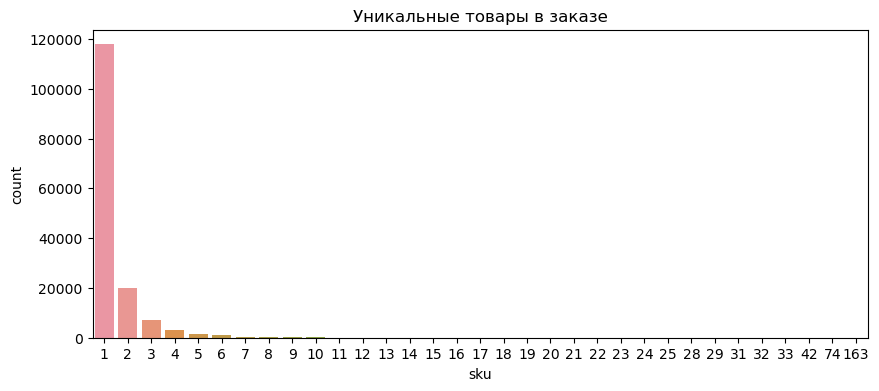

In [142]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df.groupby('orderkey')['sku'].nunique().reset_index(), x='sku')
plt.title('Уникальные товары в заказе')
plt.show()


In [143]:
round(len(df_agg.loc[df_agg['item_count']==1])/len(df_agg)*100,2)

77.53

In [144]:
round(len(df_agg.loc[df_agg['item_count']==2])/len(df_agg)*100,2)

13.15

In [145]:
round(len(df_agg.loc[df_agg['item_count']==3])/len(df_agg)*100,2)

4.68

В заказах чаще всего один уникальный товар (77,5% случаев), два товара встречаются в 13,15% случаев и 3 товара встречаются в 4,68% случаев.

In [146]:
round(len(df_agg.loc[df_agg['item_count']>3])/len(df_agg)*100,2)

4.64

В датасете заказов с уникальными товарами больше трех всего 4,63%. Удалим их из нашего исследования:

In [147]:
df_agg = df_agg.loc[df_agg['item_count']<=3]

In [148]:
df_agg

,orderkey,selected_carton,recommended_carton,pack_volume,goods_wght,item_count
0,00004fc4755eeb7e851e52ec91130fe4,MYC,MYD,3876.000,1.000,1
1,00008e765c2d85abfa9c97563afd98ef,MYB,MYA,285.000,0.135,1
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,YMF,2975.000,0.090,1
3,0000fc4c7acac6e89f82392b90e47a27,MYB,YMA,708.000,0.200,2
4,0001963724fa4cc12d4f025056085633,YMW,YMG,1237.500,0.228,2
...,...,...,...,...,...,...
151948,fffe13683b35336a4c1bb061f479f05b,MYA,MYA,121.500,0.016,1
151949,ffff1e5d7f5b52f28d733ba01a4589b9,MYC,YMU,1050.000,0.150,1
151950,ffff1f0a51126b373f36d7733a5ddb0f,MYC,MYB,1328.892,0.204,1
151951,ffff748210310fffe23e3ade55d26401,MYA,MYF,120.000,0.030,1


Теперь мы соединим все наши сведения о каждом товаре в заказе:

In [149]:
# Отфильтровываем только те значения orderkey из df, которые есть в order_agg
filtered_df = df[df['orderkey'].isin(df_agg['orderkey'])]

In [150]:
order_agg = filtered_df.pivot_table(index='orderkey', columns=filtered_df.groupby('orderkey').cumcount()+1, aggfunc='first')
order_agg.columns = [f'{col[0]}_{col[1]}' for col in order_agg.columns]
order_agg = order_agg.reset_index()

In [151]:
order_agg

,orderkey,a_1,a_2,a_3,b_1,b_2,b_3,c_1,c_2,c_3,count_1,count_2,count_3,goods_wght_1,goods_wght_2,goods_wght_3,pack_volume_1,pack_volume_2,pack_volume_3,recommended_carton_1,recommended_carton_2,recommended_carton_3,selected_carton_1,selected_carton_2,selected_carton_3,sku_1,sku_2,sku_3
0,00004fc4755eeb7e851e52ec91130fe4,17.0,NaN,NaN,38.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,1.000,NaN,NaN,3876.000,NaN,NaN,MYD,NaN,NaN,MYC,NaN,NaN,4ca57504f6b7fe26f18a93bf368a381a,NaN,NaN
1,00008e765c2d85abfa9c97563afd98ef,19.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.135,NaN,NaN,285.000,NaN,NaN,MYA,NaN,NaN,MYB,NaN,NaN,6c322b3bf34b132de6bbf7e1978e48df,NaN,NaN
2,0000c268eb1be1dd5b8c1a032f7318fc,25.0,NaN,NaN,7.0,NaN,NaN,17.0,NaN,NaN,3.0,NaN,NaN,0.090,NaN,NaN,2975.000,NaN,NaN,YMF,NaN,NaN,MYC,NaN,NaN,4557dfce2a53e74186156d84b44d0c9c,NaN,NaN
3,0000fc4c7acac6e89f82392b90e47a27,6.0,8.0,NaN,6.0,6.0,NaN,22.0,13.0,NaN,1.0,1.0,NaN,0.200,0.200,NaN,792.000,624.0,NaN,YMA,YMA,NaN,MYB,MYB,NaN,93c76085979851f91f4e276555c84efc,4ac273ebe2c3a48830ebddbdac5e74fe,NaN
4,0001963724fa4cc12d4f025056085633,10.0,15.0,NaN,12.0,17.0,NaN,10.0,5.0,NaN,6.0,4.0,NaN,0.200,0.256,NaN,1200.000,1275.0,NaN,YMG,YMG,NaN,YMW,YMW,NaN,ea767cb57a63a2727ae92e78804cadc0,3f7eb351e91999c8a3875044e979effd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144902,fffe13683b35336a4c1bb061f479f05b,9.0,NaN,NaN,1.5,NaN,NaN,9.0,NaN,NaN,1.0,NaN,NaN,0.016,NaN,NaN,121.500,NaN,NaN,MYA,NaN,NaN,MYA,NaN,NaN,1094f2dd6ccc9e6481333e7dba5b8fed,NaN,NaN
144903,ffff1e5d7f5b52f28d733ba01a4589b9,25.0,NaN,NaN,3.0,NaN,NaN,14.0,NaN,NaN,1.0,NaN,NaN,0.150,NaN,NaN,1050.000,NaN,NaN,YMU,NaN,NaN,MYC,NaN,NaN,007f5daf1d22df8ca9b9d7e6f954d8cc,NaN,NaN
144904,ffff1f0a51126b373f36d7733a5ddb0f,14.8,NaN,NaN,4.1,NaN,NaN,21.9,NaN,NaN,2.0,NaN,NaN,0.204,NaN,NaN,1328.892,NaN,NaN,MYB,NaN,NaN,MYC,NaN,NaN,87279f142e7b1eee97e7e7213332432a,NaN,NaN
144905,ffff748210310fffe23e3ade55d26401,5.0,NaN,NaN,6.0,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,0.030,NaN,NaN,120.000,NaN,NaN,MYF,NaN,NaN,MYA,NaN,NaN,80a44cb584e1b501c3961f363b45a64f,NaN,NaN


Мы получили таблицу для трех уникальных заказов, если у нас пропуски в данных, значит в заказе было менее трех уникальных товаров. Соединим имеющиеся у нас данные по столбцу orderkey:

In [152]:
df_new = df_agg.merge(order_agg, how='inner', on = 'orderkey')

In [153]:
df_new

,orderkey,selected_carton,recommended_carton,pack_volume,goods_wght,item_count,a_1,a_2,a_3,b_1,b_2,b_3,c_1,c_2,c_3,count_1,count_2,count_3,goods_wght_1,goods_wght_2,goods_wght_3,pack_volume_1,pack_volume_2,pack_volume_3,recommended_carton_1,recommended_carton_2,recommended_carton_3,selected_carton_1,selected_carton_2,selected_carton_3,sku_1,sku_2,sku_3
0,00004fc4755eeb7e851e52ec91130fe4,MYC,MYD,3876.000,1.000,1,17.0,NaN,NaN,38.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,1.000,NaN,NaN,3876.000,NaN,NaN,MYD,NaN,NaN,MYC,NaN,NaN,4ca57504f6b7fe26f18a93bf368a381a,NaN,NaN
1,00008e765c2d85abfa9c97563afd98ef,MYB,MYA,285.000,0.135,1,19.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.135,NaN,NaN,285.000,NaN,NaN,MYA,NaN,NaN,MYB,NaN,NaN,6c322b3bf34b132de6bbf7e1978e48df,NaN,NaN
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,YMF,2975.000,0.090,1,25.0,NaN,NaN,7.0,NaN,NaN,17.0,NaN,NaN,3.0,NaN,NaN,0.090,NaN,NaN,2975.000,NaN,NaN,YMF,NaN,NaN,MYC,NaN,NaN,4557dfce2a53e74186156d84b44d0c9c,NaN,NaN
3,0000fc4c7acac6e89f82392b90e47a27,MYB,YMA,708.000,0.200,2,6.0,8.0,NaN,6.0,6.0,NaN,22.0,13.0,NaN,1.0,1.0,NaN,0.200,0.200,NaN,792.000,624.0,NaN,YMA,YMA,NaN,MYB,MYB,NaN,93c76085979851f91f4e276555c84efc,4ac273ebe2c3a48830ebddbdac5e74fe,NaN
4,0001963724fa4cc12d4f025056085633,YMW,YMG,1237.500,0.228,2,10.0,15.0,NaN,12.0,17.0,NaN,10.0,5.0,NaN,6.0,4.0,NaN,0.200,0.256,NaN,1200.000,1275.0,NaN,YMG,YMG,NaN,YMW,YMW,NaN,ea767cb57a63a2727ae92e78804cadc0,3f7eb351e91999c8a3875044e979effd,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144902,fffe13683b35336a4c1bb061f479f05b,MYA,MYA,121.500,0.016,1,9.0,NaN,NaN,1.5,NaN,NaN,9.0,NaN,NaN,1.0,NaN,NaN,0.016,NaN,NaN,121.500,NaN,NaN,MYA,NaN,NaN,MYA,NaN,NaN,1094f2dd6ccc9e6481333e7dba5b8fed,NaN,NaN
144903,ffff1e5d7f5b52f28d733ba01a4589b9,MYC,YMU,1050.000,0.150,1,25.0,NaN,NaN,3.0,NaN,NaN,14.0,NaN,NaN,1.0,NaN,NaN,0.150,NaN,NaN,1050.000,NaN,NaN,YMU,NaN,NaN,MYC,NaN,NaN,007f5daf1d22df8ca9b9d7e6f954d8cc,NaN,NaN
144904,ffff1f0a51126b373f36d7733a5ddb0f,MYC,MYB,1328.892,0.204,1,14.8,NaN,NaN,4.1,NaN,NaN,21.9,NaN,NaN,2.0,NaN,NaN,0.204,NaN,NaN,1328.892,NaN,NaN,MYB,NaN,NaN,MYC,NaN,NaN,87279f142e7b1eee97e7e7213332432a,NaN,NaN
144905,ffff748210310fffe23e3ade55d26401,MYA,MYF,120.000,0.030,1,5.0,NaN,NaN,6.0,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,0.030,NaN,NaN,120.000,NaN,NaN,MYF,NaN,NaN,MYA,NaN,NaN,80a44cb584e1b501c3961f363b45a64f,NaN,NaN


Целевой признак можно выбрать либо из тех коробок, которые рекомендовал пользователь, либо из тех, которые рекомендовала система, но у нас есть цель снизить затраты на транспортировку и упаковку. Чем меньше упаковка, тем больше их можно транспортировать за один раз. Таким образом из двух коробок предложенных системой и пользователем оставим ту, чьи размеры меньше. 

У нас есть датасет с размерами коробок:

In [154]:
carton['carton_volume'] = carton['LENGTH']*carton['WIDTH']*carton['HEIGHT']

In [155]:
carton.drop(['LENGTH','WIDTH','HEIGHT'], axis=1, inplace=True)

In [156]:
carton

,CARTONTYPE,carton_volume
0,YMA,3705.000
1,YMC,9000.000
2,YME,40050.000
3,YMF,13125.000
4,YMG,26820.000
5,YMH,72240.000
6,YMJ,69600.000
7,KSD,0.000
8,YML,108000.000
9,YMN,144000.000


Присоединим объемы этих коробок в основной датасет:

In [157]:
df_new['carton_volume_sel'] = df_new['selected_carton'].map(carton.set_index('CARTONTYPE')['carton_volume'])

In [158]:
df_new['carton_volume_rec'] = df_new['recommended_carton'].map(carton.set_index('CARTONTYPE')['carton_volume'])

In [159]:
df_new.head()

,orderkey,selected_carton,recommended_carton,pack_volume,goods_wght,item_count,a_1,a_2,a_3,b_1,b_2,b_3,c_1,c_2,c_3,count_1,count_2,count_3,goods_wght_1,goods_wght_2,goods_wght_3,pack_volume_1,pack_volume_2,pack_volume_3,recommended_carton_1,recommended_carton_2,recommended_carton_3,selected_carton_1,selected_carton_2,selected_carton_3,sku_1,sku_2,sku_3,carton_volume_sel,carton_volume_rec
0,00004fc4755eeb7e851e52ec91130fe4,MYC,MYD,3876.0,1.000,1,17.0,NaN,NaN,38.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,1.000,NaN,NaN,3876.0,NaN,NaN,MYD,NaN,NaN,MYC,NaN,NaN,4ca57504f6b7fe26f18a93bf368a381a,NaN,NaN,8436.0,15580.0
1,00008e765c2d85abfa9c97563afd98ef,MYB,MYA,285.0,0.135,1,19.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.135,NaN,NaN,285.0,NaN,NaN,MYA,NaN,NaN,MYB,NaN,NaN,6c322b3bf34b132de6bbf7e1978e48df,NaN,NaN,3449.6,999.0
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,YMF,2975.0,0.090,1,25.0,NaN,NaN,7.0,NaN,NaN,17.0,NaN,NaN,3.0,NaN,NaN,0.090,NaN,NaN,2975.0,NaN,NaN,YMF,NaN,NaN,MYC,NaN,NaN,4557dfce2a53e74186156d84b44d0c9c,NaN,NaN,8436.0,13125.0
3,0000fc4c7acac6e89f82392b90e47a27,MYB,YMA,708.0,0.200,2,6.0,8.0,NaN,6.0,6.0,NaN,22.0,13.0,NaN,1.0,1.0,NaN,0.200,0.200,NaN,792.0,624.0,NaN,YMA,YMA,NaN,MYB,MYB,NaN,93c76085979851f91f4e276555c84efc,4ac273ebe2c3a48830ebddbdac5e74fe,NaN,3449.6,3705.0
4,0001963724fa4cc12d4f025056085633,YMW,YMG,1237.5,0.228,2,10.0,15.0,NaN,12.0,17.0,NaN,10.0,5.0,NaN,6.0,4.0,NaN,0.200,0.256,NaN,1200.0,1275.0,NaN,YMG,YMG,NaN,YMW,YMW,NaN,ea767cb57a63a2727ae92e78804cadc0,3f7eb351e91999c8a3875044e979effd,NaN,18000.0,26820.0


Выберем из двух коробок коробки с минимальным объемом:

In [160]:
df_new['min_volume'] = df_new[['carton_volume_sel', 'carton_volume_rec']].min(axis=1)

In [161]:
unique_carton = carton.drop_duplicates(subset='carton_volume')
df_new['box_name'] = df_new['min_volume'].map(unique_carton.set_index('carton_volume')['CARTONTYPE'])

In [162]:
df_new.head()

,orderkey,selected_carton,recommended_carton,pack_volume,goods_wght,item_count,a_1,a_2,a_3,b_1,b_2,b_3,c_1,c_2,c_3,count_1,count_2,count_3,goods_wght_1,goods_wght_2,goods_wght_3,pack_volume_1,pack_volume_2,pack_volume_3,recommended_carton_1,recommended_carton_2,recommended_carton_3,selected_carton_1,selected_carton_2,selected_carton_3,sku_1,sku_2,sku_3,carton_volume_sel,carton_volume_rec,min_volume,box_name
0,00004fc4755eeb7e851e52ec91130fe4,MYC,MYD,3876.0,1.000,1,17.0,NaN,NaN,38.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,1.000,NaN,NaN,3876.0,NaN,NaN,MYD,NaN,NaN,MYC,NaN,NaN,4ca57504f6b7fe26f18a93bf368a381a,NaN,NaN,8436.0,15580.0,8436.0,MYC
1,00008e765c2d85abfa9c97563afd98ef,MYB,MYA,285.0,0.135,1,19.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.135,NaN,NaN,285.0,NaN,NaN,MYA,NaN,NaN,MYB,NaN,NaN,6c322b3bf34b132de6bbf7e1978e48df,NaN,NaN,3449.6,999.0,999.0,MYA
2,0000c268eb1be1dd5b8c1a032f7318fc,MYC,YMF,2975.0,0.090,1,25.0,NaN,NaN,7.0,NaN,NaN,17.0,NaN,NaN,3.0,NaN,NaN,0.090,NaN,NaN,2975.0,NaN,NaN,YMF,NaN,NaN,MYC,NaN,NaN,4557dfce2a53e74186156d84b44d0c9c,NaN,NaN,8436.0,13125.0,8436.0,MYC
3,0000fc4c7acac6e89f82392b90e47a27,MYB,YMA,708.0,0.200,2,6.0,8.0,NaN,6.0,6.0,NaN,22.0,13.0,NaN,1.0,1.0,NaN,0.200,0.200,NaN,792.0,624.0,NaN,YMA,YMA,NaN,MYB,MYB,NaN,93c76085979851f91f4e276555c84efc,4ac273ebe2c3a48830ebddbdac5e74fe,NaN,3449.6,3705.0,3449.6,MYB
4,0001963724fa4cc12d4f025056085633,YMW,YMG,1237.5,0.228,2,10.0,15.0,NaN,12.0,17.0,NaN,10.0,5.0,NaN,6.0,4.0,NaN,0.200,0.256,NaN,1200.0,1275.0,NaN,YMG,YMG,NaN,YMW,YMW,NaN,ea767cb57a63a2727ae92e78804cadc0,3f7eb351e91999c8a3875044e979effd,NaN,18000.0,26820.0,18000.0,YMW


In [163]:
df_new.loc[df_new['min_volume'] == 0.00, 'box_name'] = 'NONPACK'

Теперь, когда у нас есть улучшенный целевой признак, мы можем избавиться от всех столбцов, которые будут мешать обучению модели:

In [164]:
df_new.drop(['orderkey', 'selected_carton_1', 'selected_carton_2', 'selected_carton_3', 
'recommended_carton_1', 'recommended_carton_2', 'recommended_carton_3', 'sku_1', 'sku_2', 'sku_3', 
'selected_carton', 'recommended_carton', 'carton_volume_sel', 'carton_volume_rec', 'min_volume'], axis=1, inplace=True)

In [165]:
df_new

,pack_volume,goods_wght,item_count,a_1,a_2,a_3,b_1,b_2,b_3,c_1,c_2,c_3,count_1,count_2,count_3,goods_wght_1,goods_wght_2,goods_wght_3,pack_volume_1,pack_volume_2,pack_volume_3,box_name
0,3876.000,1.000,1,17.0,NaN,NaN,38.0,NaN,NaN,6.0,NaN,NaN,1.0,NaN,NaN,1.000,NaN,NaN,3876.000,NaN,NaN,MYC
1,285.000,0.135,1,19.0,NaN,NaN,3.0,NaN,NaN,5.0,NaN,NaN,1.0,NaN,NaN,0.135,NaN,NaN,285.000,NaN,NaN,MYA
2,2975.000,0.090,1,25.0,NaN,NaN,7.0,NaN,NaN,17.0,NaN,NaN,3.0,NaN,NaN,0.090,NaN,NaN,2975.000,NaN,NaN,MYC
3,708.000,0.200,2,6.0,8.0,NaN,6.0,6.0,NaN,22.0,13.0,NaN,1.0,1.0,NaN,0.200,0.200,NaN,792.000,624.0,NaN,MYB
4,1237.500,0.228,2,10.0,15.0,NaN,12.0,17.0,NaN,10.0,5.0,NaN,6.0,4.0,NaN,0.200,0.256,NaN,1200.000,1275.0,NaN,YMW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144902,121.500,0.016,1,9.0,NaN,NaN,1.5,NaN,NaN,9.0,NaN,NaN,1.0,NaN,NaN,0.016,NaN,NaN,121.500,NaN,NaN,MYA
144903,1050.000,0.150,1,25.0,NaN,NaN,3.0,NaN,NaN,14.0,NaN,NaN,1.0,NaN,NaN,0.150,NaN,NaN,1050.000,NaN,NaN,YMU
144904,1328.892,0.204,1,14.8,NaN,NaN,4.1,NaN,NaN,21.9,NaN,NaN,2.0,NaN,NaN,0.204,NaN,NaN,1328.892,NaN,NaN,MYB
144905,120.000,0.030,1,5.0,NaN,NaN,6.0,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,0.030,NaN,NaN,120.000,NaN,NaN,MYA


Можно также заменить все пропуски на 0:

In [166]:
df_new = df_new.fillna(0)

In [167]:
df_new['box_name'].value_counts()

MYB        30606
MYC        22511
MYA        22497
NONPACK    22204
YMA        13382
MYF         7878
YMC         7437
MYD         5536
YMF         5159
YMW         2487
MYE         1934
YMG         1538
YMU          813
YME          555
YMV          226
YML           95
YMХ           49
Name: box_name, dtype: int64

# Обучение

In [168]:
X = df_new.drop('box_name', axis=1).reset_index(drop=True)
y = df_new['box_name']


In [169]:
encoder = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1)

In [170]:
y_encoded = encoder.fit_transform(y.values.reshape(-1,1))

In [171]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X.values, y_encoded, test_size=0.25)

In [172]:
X_train.shape

(108680, 21)

In [173]:
X_test.shape

(36227, 21)

## Тюнинг с помощью Optuna

In [174]:
#def objective(trial, data=X_train, target=y_train):
    #X_train_new, y_train_new, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.30)

    #params = {
        #'iterations': 2000,
        #'early_stopping_rounds': 20,
        #'loss_function': 'MultiClass',
        #'verbose': 0,
        #'depth': trial.suggest_int('depth', 4, 10),
        #'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        #'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True),
        #'border_count': trial.suggest_int('border_count', 32, 255)
    #}
       
    #model = CatBoostClassifier(**params)

    #model.fit(X_train_new, y_train_new, 
    #eval_set = (X_val, y_val))

    #y_pred_proba = model.predict_proba(X_val)
    #predicted_labels = np.argmax(y_pred_proba, axis=1)
    #f1_score_val = f1_score(y_val, predicted_labels, average='weighted')

    #return f1_score_val
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=5, n_jobs= -1)
#print('Best params:', study.best_params)
#print('Best value:', study.best_value)

## Модель

In [175]:
tun_model = CatBoostClassifier(
    iterations= 2000, # сколько деревьев в ансамбле
    learning_rate = 0.1394345210078686, #регурялизация бустинга
    early_stopping_rounds=20, #ограничение на обучение (в данном случае если 20 эпох подряд качество ухудшается модель перестает обучаться)
    loss_function='MultiClass',
    random_seed=42,
    depth = 5,
    l2_leaf_reg = 3.3457380467351436,
    border_count = 191,
    verbose=0 #если вербосс = 0, модель не будет выводить на экран процесс обучения
)

In [176]:
X_train, y_train, X_val, y_val = iterative_train_test_split(X_train, y_train, test_size=0.25)

In [177]:
tun_model.fit(
    X_train, y_train, eval_set = (X_val, y_val))

In [178]:
y_pred_proba = tun_model.predict_proba(X_test)

Выполним раскодировку:

In [179]:
predicted_labels = np.argmax(y_pred_proba, axis=1)
y_pred = encoder.inverse_transform(predicted_labels.reshape(-1, 1))

In [180]:
y_test = encoder.inverse_transform(y_test)

In [181]:
report_dict = classification_report(y_test, y_pred, output_dict=True)

In [182]:
report_df = pd.DataFrame(report_dict).transpose()

In [183]:
report_df 

,precision,recall,f1-score,support
MYA,0.830592,0.718222,0.770331,5625.000000
MYB,0.623562,0.688409,0.654382,7635.000000
MYC,0.565602,0.697637,0.624719,5586.000000
MYD,0.488909,0.385007,0.430782,1374.000000
MYE,0.228395,0.074148,0.111952,499.000000
MYF,0.680623,0.650924,0.665442,1948.000000
NONPACK,0.732867,0.841392,0.783389,5605.000000
YMA,0.572710,0.457313,0.508548,3350.000000
YMC,0.499383,0.435953,0.465517,1858.000000
YME,0.285714,0.166667,0.210526,132.000000



Анализируя таблицу с метриками оценки модели многоклассовой классификации, можно сделать следующие наблюдения:

Классы с высокими значениями precision, recall и f1-score (более 0.7) означают, что модель хорошо предсказывает эти классы и имеет низкую частоту ошибок:

- Класс 'MYA' имеет высокую точность (0.811) и хорошую полноту (0.712), что указывает на высокую способность модели правильно классифицировать этот класс.
- Класс 'MYB' также имеет высокую точность (0.616) и хорошую полноту (0.677), что указывает на эффективность модели в предсказании этого класса.
- Класс 'MYC' имеет сбалансированные значения precision (0.559) и recall (0.688), что говорит о том, что модель хорошо справляется с этим классом.
- Класс 'NONPACK' имеет высокие значения всех метрик (точность 0.723, полнота 0.848, F1-мера 0.780), что свидетельствует о хорошей способности модели предсказывать этот класс.
Классы с низкими значениями precision, recall и f1-score (менее 0.5) указывают на слабую способность модели правильно классифицировать эти классы:

- Класс 'YME' имеет низкую точность (0.185) и полноту (0.100), что говорит о том, что модель часто дает ложные положительные и ложные отрицательные результаты для этого класса.
- Класс 'YMG' также имеет низкую точность (0.313) и полноту (0.209), указывая на слабую способность модели правильно предсказывать этот класс.
- Класс 'YMХ' имеет значения всех метрик равные нулю, что указывает на то, что модель не смогла предсказать этот класс ни в одном случае.
Классы средней эффективности классификации (precision, recall и f1-score около 0.5-0.7) требуют дополнительного изучения и анализа:

- Класс 'YMC' имеет сбалансированные значения метрик (точность 0.487, полнота 0.435, F1-мера 0.460).
- Класс 'YMF' имеет средние значения метрик (точность 0.416, полнота 0.393, F1-мера 0.404).


Accuracy (0.627) показывает, что модель правильно классифицирует около 62,7% образцов.
Macro avg (средневзвешенное значение всех метрик) составляет примерно 0.489 для precision, 0.400 для recall и 0.428 для F1-меры.
Weighted avg (взвешенное среднее значение метрик, учитывая размеры классов) составляет примерно 0.621 для precision, 0.627 для recall и 0.619 для F1-меры.
Общий вывод состоит в том, что модель показывает хорошие результаты в предсказании некоторых классов, но имеет проблемы с другими классами. Для улучшения производительности модели нужно увеличить присутствие некоторых классов коробок в датасете. 

Визуализируем матрицу ошибок:

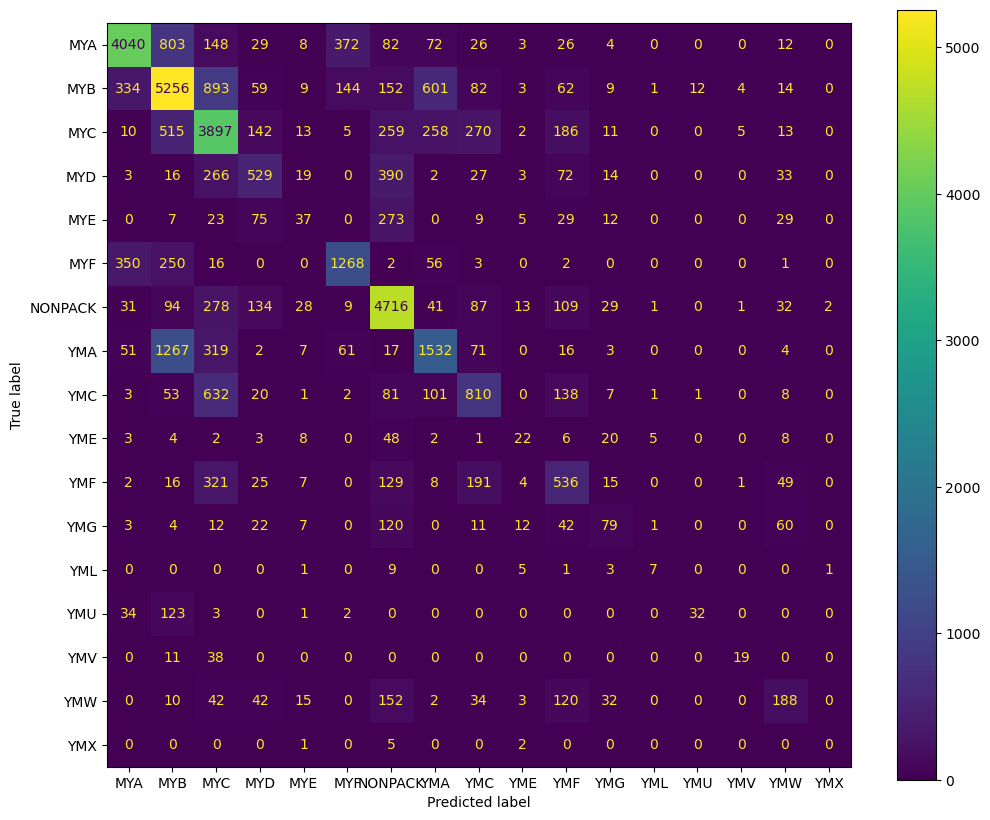

In [184]:
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Установка размера графика
plt.rc('figure', figsize=(12, 10))


In [185]:
# Сохранение модели в файл
with open("file_tun.pcl", "wb") as fid:
    pickle.dump(tun_model, fid)

In [ ]:
# Сохранение кодировщика на диск
joblib.dump(encoder, 'encoder.pkl')

# Вывод:

Удалось решить задачу для оптимизации рабочего процесса и разработать модель машинного обучения, которая поможет пользователю подобрать правильную упаковку для заказа. Модель показала неплохие результаты на общих метриках, таких как точность (precision), полнота (recall) и F1-мера (f1-score). Однако, при более детальном рассмотрении метрик для каждого класса, видно, что модель имеет проблемы с некоторыми классами.

В основном, это происходит из-за недостатка информации о некоторых заказах в обучающем наборе данных. Например, модель не смогла правильно предсказать класс "YMX", так как в общем объеме данных (144 тыс. строк) всего было 49 примеров этого класса. Недостаток представительных примеров для определенных классов может привести к низкой способности модели к их правильной классификации.

Для улучшения результатов модели можно рассмотреть следующие шаги:

- Собрать больше данных о заказах, упакованных в коробки класса "YMX". Увеличение числа представительных примеров этого класса позволит модели лучше обучиться и улучшит ее способность к правильной классификации.

- Провести дополнительный анализ признаков и важности для каждого класса. Понимание значимости и влияния каждого признака на предсказания может помочь оптимизировать модель и ее параметры.

В целом, разработка модели машинного обучения для рекомендации упаковочного материала является полезным шагом в оптимизации рабочего процесса. Однако, для достижения более высокой точности и качества предсказаний, необходимо уделить внимание устранению проблем с недостатком данных. 